## Variational Quantum Deflation (VQD)

VQD is an algorithm for computing higher energy states of a Hamiltonian. 

The algorithm computes excited state energies of generalized hamiltonians by optimizing over a modified cost function. Each successive eigenvalue is calculated iteratively by introducing an overlap term with all previously computed eigenstates that must be minimized. This ensures higher energy eigenstates are found. 

The first step of VQD is to create a qubit operator, ansatz, and optimizer. We will again use the H2 molecule 

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

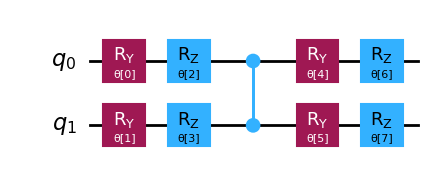

In [34]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SLSQP 

ansatz = TwoLocal(2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps = 1)

optimizer = SLSQP(maxiter = 30)
ansatz.decompose().draw('mpl')

This algorithm requires two different primitive instances: one `Estimator` for computing expectation values for the "VQE" part of the algorithm, and one `Sampler`. The sampler will be passed along to the `StateFidelity` subroutine that will be used to compute the cost for higher energy states. There are several methods you can use to compute state fidelities, but to keep things simple, you can use the `ComputeUncompute` method available in `qiskit_algorithms.state_fidelities`. 

In [39]:
from qiskit.primitives import Sampler, Estimator
from qiskit_algorithms.state_fidelities import ComputeUncompute

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

We need two more inputs: the number `k` for how many eigenstates we wish to calculate. And `betas`, defined in the original paper. The latter is optional and if not defined, can be autoevaluated for input operators of type `SparsePauliOp`. 

In [40]:
k = 3
betas = [33, 33, 33]

In [41]:
# callback 
counts = []
values = []
steps  = [] 

def callback(eval_count, params, value, meta, step): 
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [42]:
from qiskit_algorithms.eigensolvers import VQD

vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas = betas, callback = callback)
result = vqd.compute_eigenvalues(operator = H2_op)
vqd_values = result.eigenvalues

In [43]:
print(vqd_values.real)

[-1.85727464 -1.24458443 -0.88272209]


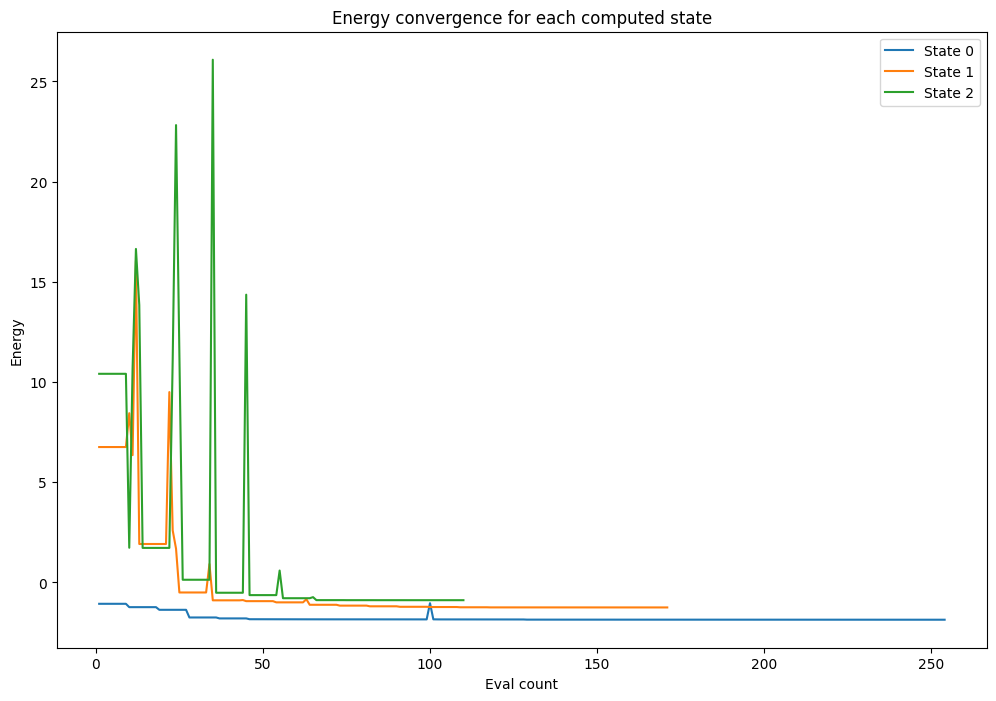

In [44]:
import numpy as np
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)

steps = np.asarray(steps)
counts = np.asarray(counts)
values = np.asarray(values)

for i in range(1,4):
    _counts = counts[np.where(steps == i)]
    _values = values[np.where(steps == i)]
    pylab.plot(_counts, _values, label=f"State {i-1}")
    
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for each computed state")
pylab.legend(loc="upper right");

We can calculate the exact eigenvalues using numpy

In [31]:
from qiskit_algorithms.eigensolvers import NumPyEigensolver

exact_solver = NumPyEigensolver(k = k)
exact_result = exact_solver.compute_eigenvalues(H2_op)
ref_values = exact_result.eigenvalues

In [33]:
print(f'Reference Values: {ref_values}')
print(f'VQD values:  {vqd_values.real}')

Reference Values: [-1.85727503 -1.24458455 -0.88272215]
VQD values:  [-1.85727456 -1.24458407 -0.88272224]
